In [6]:
##############################################################################
#
# This code is part of the publication:
# https://www.biorxiv.org/content/10.1101/2020.11.30.403840v1
#
# The generation of cortical novelty responses through inhibitory plasticity
# Auguste Schulz*, Christoph Miehl*, Michael J. Berry II, Julijana Gjorgjieva
#
# * equal contribution
#
##############################################################################

# Figure 3

Author: Auguste Schulz  
1. Population responseall seqs avg multiple blocks
2. Population response shuffled
3. Population response switch B and C
4. Reduced novelty

In [5]:
from IPython.display import HTML, IFrame, Image

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os, fnmatch
import time
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy import stats
from scipy import optimize
from scipy.signal import decimate
from scipy import signal
import gc
import time

%matplotlib inline


from matplotlib import rcParams, cm
rcParams['grid.linewidth'] = 0
rcParams['pdf.fonttype'] = 42
# import custom functions
from helper_functions import *
import helper_functions

#reload(helper_functions)
from helper_functions import *

from evaluation_functions import *
import evaluation_functions

#reload(evaluation_functions)
from evaluation_functions import *

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def get_time_idx(time, onsets):
    idx = []
    for tt in onsets:
        #print(tt)
        #print(min(min(np.where(tt<=time))))
        idx.append(min(min(np.where(time>=tt))))
        
    return idx

figsize_cm = (20,10)
figsize_inch = cm2inch(figsize_cm)
figsize_inch


(7.874015748031496, 3.937007874015748)

In [2]:
file_names = [
    
    "PREDS_shuffled_false_reducednovelty_false_lastshuffled_true_INHIB_0.1__ifinhibhetero_false_dur943000.0msNblocks10Ntrain2lenstim300lenpause0Nreps20strength12wadaptfalseiSTDPtrueRateAdjust1.0Time2020-02-24-19-59-38shufflenoveltyrepeatedsequences.h5",
    "PREDS_shuffled_false_reducednovelty_true_lastshuffled_false_INHIB_0.1__ifinhibhetero_false_dur943000.0msNblocks10Ntrain2lenstim300lenpause0Nreps20strength12wadaptfalseiSTDPtrueRateAdjust1.0Time2020-02-24-19-57-24reducednovrepeatedsequences.h5",
    "PREDS_shuffled_true_reducednovelty_false_lastshuffled_false_INHIB_0.1__ifinhibhetero_false_dur943000.0msNblocks10Ntrain2lenstim300lenpause0Nreps20strength12wadaptfalseiSTDPtrueRateAdjust1.0Time2020-02-24-19-58-38repeatedsequencesshuffled.h5",
    "INHIB_0.1__ifinhibhetero_false_dur943000.0msNblocks10Ntrain2lenstim300lenpause0Nreps20strength12wadaptfalseiSTDPtrueRateAdjust1.0Time2020-02-24-19-15-46repeatedsequences.h5"
    
]

E_all  = []
I_all = []
ed_all = []
FIG_DIR_ALL = []
Xweight_all = []
ItoAweight_all = []
timevector_all = []
avgweightEmem_all = []
avgweightImem_all = []
avgweightEnov_all = []
avgweightImem_all = []
avgwindow = 4
timestr = time.strftime("%Y-%m-%d-%H-%M-%S")


RUN_DIR = "../data/"
RESULTS_DIR = "../results/"

FILE_NAME_RUN = [RUN_DIR + file_name for file_name in file_names]
#file_name_run = run_folder + file_name
# open file
frun = h5py.File(FILE_NAME_RUN[0], "r")

FILE_NAME_RUN[-1]
dict_dursimspikes_last  = frun["dursimspikes"]
dict_dursimspikes_keys = dict_dursimspikes_last.keys()
dict_dursimspikes_keys;
adjustfact  = frun["params"]['adjustfactorinhib2'].value
stimulus  = frun["initial"]['stimulus'].value
ptretrain  = frun["initial"]['lengthpretrain'].value

print(stimulus[:,-1])
print(stimulus[2,ptretrain])
dict_dursimspikes_last= frun["dursimspikes"].keys()
dict_dursimspikes_last;
print(frun["initial"].keys())

[3.000e+00 9.427e+05 9.430e+05 1.200e+01]
43300.0
<KeysViewHDF5 ['assemblymembers', 'idxblockonset', 'inhibassemblies', 'lengthpretrain', 'seqnumber', 'stimparams', 'stimparams_prestim', 'stimulus', 'weights']>


/home/auguste/Software/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


NON ADAPTIVE
PREDS_shuffled_false_reducednovelty_false_lastshuffled_true_INHIB_0.1__ifinhibhetero_false_dur943000.0msNblocks10Ntrain2lenstim300lenpause0Nreps20strength12wadaptfalseiSTDPtrueRateAdjust1.0Time2020-02-24-19-59-38shufflenoveltyrepeatedsequences.h5
NON ADAPTIVE
PREDS_shuffled_false_reducednovelty_true_lastshuffled_false_INHIB_0.1__ifinhibhetero_false_dur943000.0msNblocks10Ntrain2lenstim300lenpause0Nreps20strength12wadaptfalseiSTDPtrueRateAdjust1.0Time2020-02-24-19-57-24reducednovrepeatedsequences.h5
NON ADAPTIVE
PREDS_shuffled_true_reducednovelty_false_lastshuffled_false_INHIB_0.1__ifinhibhetero_false_dur943000.0msNblocks10Ntrain2lenstim300lenpause0Nreps20strength12wadaptfalseiSTDPtrueRateAdjust1.0Time2020-02-24-19-58-38repeatedsequencesshuffled.h5
NON ADAPTIVE
INHIB_0.1__ifinhibhetero_false_dur943000.0msNblocks10Ntrain2lenstim300lenpause0Nreps20strength12wadaptfalseiSTDPtrueRateAdjust1.0Time2020-02-24-19-15-46repeatedsequences.h5
NON ADAPTIVE
12
Repeated sequences on
novelt

90

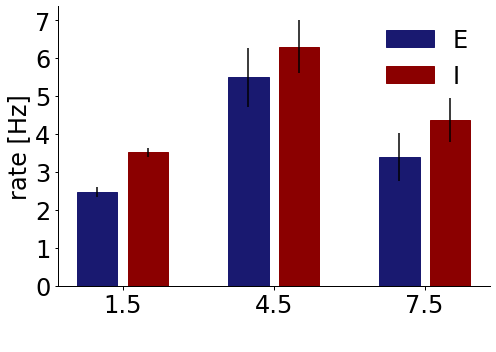

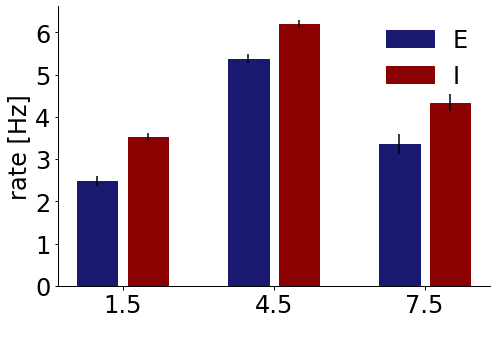

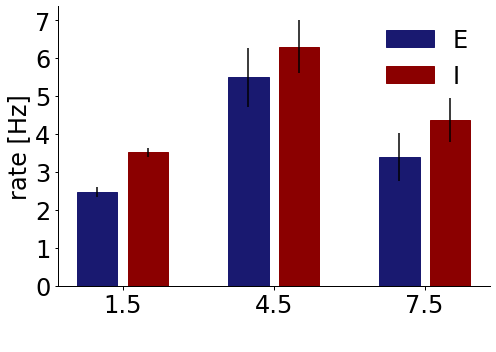

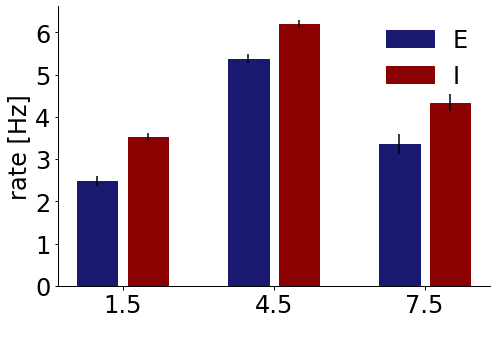

In [3]:
for i,fn in enumerate(file_names):
    E,I, ed, E_hist, E_hist_boxcar, FIG_DIR,_ = analyse_filename(fn, avgwindow=avgwindow, timestr=timestr, RUN_DIR = RUN_DIR, RESULTS_DIR=RESULTS_DIR)
    print(fn)
    E_all.append(E)
    I_all.append(I)
    ed_all.append(ed)
    FIG_DIR_ALL.append(FIG_DIR)
    
    gc.collect()
spiketimes = 0
gc.collect()

# run further evaluations for the standard repeated sequence case to compare inhibitory and excitatory population responses
avgwindow = 4
timestr = time.strftime("%Y-%m-%d-%H-%M-%S")
E,I, ed, E_hist, E_hist_boxcar, FIG_DIR, barplot_peak, barplot_peak_avg = repeated_sequence_analysis(file_names[-1], avgwindow=avgwindow, timestr=timestr, RUN_DIR = RUN_DIR, RESULTS_DIR=RESULTS_DIR)
height_novelty, height_noveltyI, height_trans_pre, height_trans_preI, baseline, baselineI = barplot_peak
height_novelty_avg, height_novelty_avgI, height_trans_pre_avg, height_trans_pre_avgI, baseline_avg, baseline_avgI = barplot_peak_avg

barplot_peak_comparison_EI(height_novelty, height_noveltyI, height_trans_pre, height_trans_preI, baseline, baselineI, iflegend=True, figure_directory=FIG_DIR, ifsavefig = False, xlabel=" ", alpha = 1)
barplot_peak_comparison_EI(height_novelty_avg, height_novelty_avgI, height_trans_pre_avg, height_trans_pre_avgI, baseline_avg, baseline_avgI, iflegend=True, figure_directory=FIG_DIR, ifsavefig = False, xlabel=" ", alpha = 1, savename = "ComparisonPeakHeightsBarPlot_averages")
    
spiketimes = 0
gc.collect()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


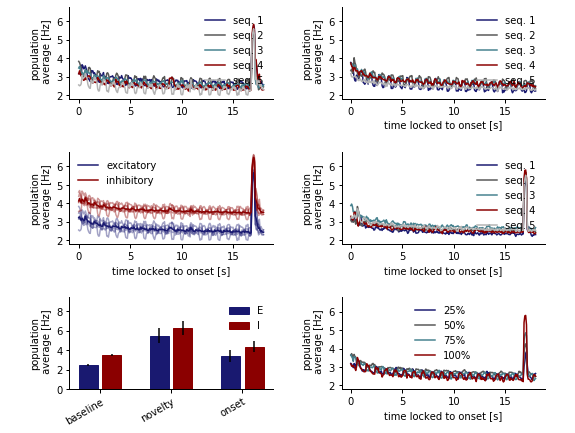

In [4]:
E_lastshuffle = E_all[0]
ed_lastshuffle = ed_all[0]
E_rednov = E_all[1]
ed_rednov = ed_all[1]
E_shuffle = E_all[2]
ed_shuffle = ed_all[2]
E_std = E_all[-1]
ed_std = ed_all[-1]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


axiswidth=1
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
figsize_cm = (20,15)
figsize_inch = cm2inch(figsize_cm)
figsize_inch
fig2 = plt.figure(constrained_layout=True, figsize=figsize_inch)
gs = fig2.add_gridspec(32, 21, hspace=0.5)

f2_ax1 = fig2.add_subplot(gs[0:10, 1:10])
#f2_ax1.set_title('1:all weights')

f2_ax2 = fig2.add_subplot(gs[11:21, 1:10])
#f2_ax2.set_title('2:trace seq 1 bl 1')

f2_ax3 = fig2.add_subplot(gs[22:, 1:10])#, sharex=f2_ax2)
#f2_ax3.set_title('3:weight 1')

f2_ax4 = fig2.add_subplot(gs[0:10, 11:20])
#f2_ax1.set_title('1:all weights')

f2_ax5 = fig2.add_subplot(gs[11:21, 11:20])
#f2_ax2.set_title('2:trace seq 1 bl 1')

f2_ax6 = fig2.add_subplot(gs[22:,11:20])#, sharex=f2_ax2)


for aa, ax in enumerate([f2_ax1,f2_ax2,f2_ax3,f2_ax4,f2_ax5,f2_ax6]):
    for axis in ['bottom', 'left']:
            ax.spines[axis].set_linewidth(axiswidth)
    for axis in ['top', 'right']:
        ax.spines[axis].set_linewidth(0)
    ax.xaxis.set_tick_params(width=axiswidth)
    ax.yaxis.set_tick_params(width=axiswidth)
    ax.locator_params(tight=True, nbins=5)
save_fig(FIG_DIR, "Figure_template")

# ===============================================0 begin plotting ===============================================
Nseq = 5
Nimg = 3
color = ["midnightblue","lightskyblue","royalblue","darkred","darksalmon", "saddlebrown","darkgreen","greenyellow","darkolivegreen","darkmagenta","thistle","indigo","darkorange","tan","sienna", "black", "silver","dimgrey", "fuchsia", "orchid","plum",  "lightseagreen", "lightcyan", "darkslategray",  "goldenrod","gold", "wheat","forestgreen", "aquamarine", "palegreen"]
colormain = color[0:Nimg*Nseq:Nimg]
colormain = ['#191970', '#575756', '#45818E', '#8B0000', '#B4B4B4']

colormain
cutoff = 1

# ================================================ repeated sequences =================================================
for i, trace in enumerate(E):
    #print(i)
    f2_ax1.plot(ed[:-cutoff], trace[:-cutoff], color = colormain[i], label = f'seq. {i+1}')
   

        
f2_ax1.legend(frameon=False)
f2_ax1.set(ylabel ="population\n average [Hz]")


    #f2_ax2.plot(ed[:-cutoff], trace[:-cutoff], color = colormain[i], label = f'seq. {str(i+1)}')
for i, trace in enumerate(E):
    #print(i)
    f2_ax2.plot(ed[:-cutoff], trace[:-cutoff], color = 'midnightblue', alpha = 0.4)
for i, trace in enumerate(I):
    f2_ax2.plot(ed[:-cutoff], trace[:-cutoff], color = 'darkred', alpha = 0.4)
    #f2_ax2.plot(ed[:-cutoff], trace[:-cutoff], color = colormain[i], label = f'seq. {str(i+1)}')
E_avg = np.mean(E,axis=0)
I_avg = np.mean(I,axis=0)
f2_ax2.plot(ed[:-cutoff], E_avg[:-cutoff], color = 'midnightblue', label = 'excitatory')
f2_ax2.plot(ed[:-cutoff], I_avg[:-cutoff], color = 'darkred', label = 'inhibitory')
    
f2_ax2.legend(frameon=False)
f2_ax2.set(ylabel ="population\n average [Hz]", xlabel = "time locked to onset [s]")

barplot_peak_comparison_ax(f2_ax3, height_novelty, height_noveltyI, height_trans_pre, height_trans_preI, baseline, baselineI, iflegend=True, figure_directory=FIG_DIR, ifsavefig = False, xlabel=" ", alpha = 1)
f2_ax3.set(ylabel ="population\n average [Hz]")
f2_ax3.set(xticks = [1.5,4.5, 7.5])
f2_ax3.set_ylim([0,9.5])
f2_ax3.set_xticklabels(['baseline','novelty','onset'])
plt.setp(f2_ax3.get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")


# ================================================ swap last two =================================================
for i, trace in enumerate(E_lastshuffle):
    #print(i)
    f2_ax4.plot(ed_std[:-cutoff], trace[:-cutoff], color = colormain[i], label = f'seq. {str(i+1)}')
f2_ax4.legend(frameon=False)
f2_ax4.set(ylabel ="population\n average [Hz]")
f2_ax4.set(xlabel = "time locked to onset [s]")

# ================================================ shuffled =================================================
for i, trace in enumerate(E_shuffle):
    #print(i)
    f2_ax5.plot(ed_std[:-cutoff], trace[:-cutoff], color = colormain[i], label = f'seq. {str(i+1)}')
f2_ax5.legend(frameon=False)
f2_ax5.set(xlabel = "time locked to onset [s]")
f2_ax5.set(ylabel ="population\n average [Hz]")

# ================================================ reduced novelty =================================================
strength = [25,50,75,100] # novelty stimulation strength in percent relative to standard stimulation strength
for i, trace in enumerate(E_rednov[1:]):
    #print(i)
    f2_ax6.plot(ed_std[:-cutoff], trace[:-cutoff], color = colormain[i], label = f'{strength[i]}%')
f2_ax6.legend(frameon=False)
f2_ax6.set(xlabel = "time locked to onset [s]", ylabel ="population\n average [Hz]")

f2_ax1.set_ylim([1.8,6.8])
f2_ax2.set_ylim([1.8,6.8])
f2_ax4.set_ylim([1.8,6.8])
f2_ax5.set_ylim([1.8,6.8])
f2_ax6.set_ylim([1.8,6.8])

save_fig("./figures/","Figure_3_Rep_Seq_Predictions")
